In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from spacy.util import minibatch, compounding
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy

# Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
# ID column should be the index, minus the id part of the data

In [5]:
train['id'] = train['id'].str[2:]

#it column, should be the id column starting from the 3rd letter of the string

In [6]:
train.head()

,id,text,author
0,26305,"This process, however, afforded me no means of...",EAP
1,17569,It never once occurred to me that the fumbling...,HPL
2,11008,"In his left hand was a gold snuff box, from wh...",EAP
3,27763,How lovely is spring As we looked from Windsor...,MWS
4,12958,"Finding nothing else, not even gold, the Super...",HPL


In [7]:
train.set_index('id', inplace=True)

In [8]:
train.head()

,text,author
id,,
26305,"This process, however, afforded me no means of...",EAP
17569,It never once occurred to me that the fumbling...,HPL
11008,"In his left hand was a gold snuff box, from wh...",EAP
27763,How lovely is spring As we looked from Windsor...,MWS
12958,"Finding nothing else, not even gold, the Super...",HPL


In [9]:
test.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [10]:
test['id'] = test['id'].str[2:]
test.set_index('id', inplace=True)

In [11]:
test.head()

,text
id,
02310,"Still, as I urged our leaving Ireland with suc..."
24541,"If a fire wanted fanning, it could readily be ..."
00134,And when they had broken down the frail door t...
27757,While I was thinking how I should possibly man...
04081,I am not sure to what limit his knowledge may ...


# Exploratory Data Analysis

In [12]:
print(test.shape)
print(train.shape)

(8392, 1)
(19579, 2)


In [13]:
# test is 2 columns, the id index and the text
# train data is 3, id text and the authors name

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19579 entries, 26305 to 00393
Data columns (total 2 columns):
text      19579 non-null object
author    19579 non-null object
dtypes: object(2)
memory usage: 458.9+ KB


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8392 entries, 02310 to 04282
Data columns (total 1 columns):
text    8392 non-null object
dtypes: object(1)
memory usage: 131.1+ KB


### Visualization

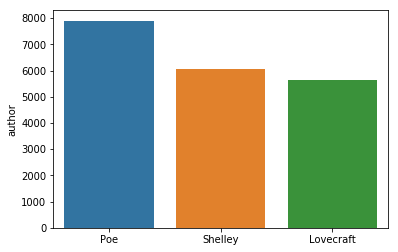

In [16]:
sns.barplot(x=['Poe', 'Shelley', 'Lovecraft'], y=train['author'].value_counts())

In [17]:
#from here we see the majority of data is Poe then the other two

In [18]:
poe = train[train['author'] == 'EAP']
shelly = train[train['author'] == 'MWS']
hpl = train[train['author'] == 'HPL']

In [19]:
poe['text'][1]

'In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.'

In [20]:
len(poe)

7900

In [21]:
poe_text = ' '.join(text for text in poe['text'])
len(poe_text)

1131484

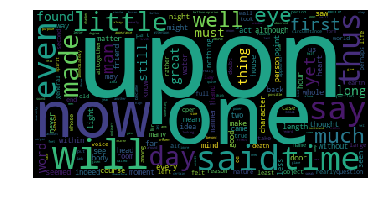

In [22]:
wordcloud_poe = WordCloud().generate(poe_text)
plt.figure()
plt.imshow(wordcloud_poe)
plt.axis('off')
plt.show()

In [23]:
shelly_text = ' '.join(text for text in shelly['text'])
len(shelly_text)

922675

In [30]:
hpl_text = ' '.join(text for text in hpl['text'])
len(hpl_text)

883812

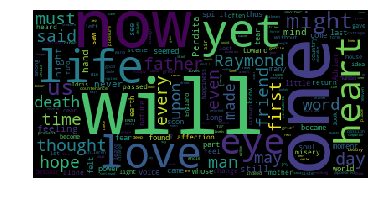

In [31]:
wordcloud_shelly = WordCloud().generate(shelly_text)
plt.figure()
plt.imshow(wordcloud_shelly)
plt.axis('off')
plt.show()

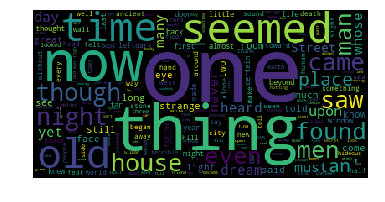

In [32]:
wordcloud_hpl = WordCloud().generate(hpl_text)
plt.figure()
plt.imshow(wordcloud_hpl)
plt.axis('off')
plt.show()

# Text Pre-Processing

In [33]:
train = pd.DataFrame(data = (train['text'], train['author']))

train = train.transpose()

train_texts = train['text']
train_cats = train['author']
test_texts = test['text']


cats_values = train_cats.unique()
labels_default = dict((v,0) for v in cats_values)

train_data = []
for i, column in train.iterrows():
    
    label_values = copy.deepcopy(labels_default)
    label_values[column['author']] = 1
    
    train_data.append((str(column['text']), {"cats": label_values}))

# Model

In [34]:
nlp = spacy.blank("en")  # create blank Language class


# add the text classifier to the pipeline if it doesn't exist
# nlp.create_pipe works for built-ins that are registered with spaCy

textcat = nlp.create_pipe(
    "textcat", config={"exclusive_classes": True, "architecture": "simple_cnn"}
)
nlp.add_pipe(textcat, last=True)

# add label to text classifier
textcat.add_label("EAP")
textcat.add_label("HPL")
textcat.add_label("MWS")
assert "EAP" in textcat.labels
assert "HPL" in textcat.labels
assert "MWS" in textcat.labels
cats = {"EAP": 'EAP', "HPL": 'HPL', "MWS": 'MWS'}

In [35]:
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "textcat"]
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()
    print("Training the model...")
    print("{:^5}\t".format("LOSS"))
    batch_sizes = compounding(4.0, 32.0, 1.001)
    for i in range(20):
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(train_data, size=batch_sizes)
        for batch in batches:
            texts, cats = zip(*batch)
            nlp.update(texts, cats, sgd=optimizer, drop=0.2, losses=losses)
        print(
            "{0:.3f}".format(  # print a simple table
                losses["textcat"])
        )

output_dir = "E:\\Documents\\Data Science\\github\\ubiquitous-eureka\\author_identification_spacy"

with nlp.use_params(optimizer.averages):
    nlp.to_disk(output_dir)
print("Saved model to", output_dir)

Training the model...
LOSS 	
19.474
0.199
0.134
0.113
0.091
0.077
0.067
0.056
0.050
0.046
0.043
0.038
0.035
0.032
0.030
0.027
0.024
0.023
0.022
0.022
Saved model to E:\Documents\Data Science\github\ubiquitous-eureka\author_identification_spacy


### Model Evaluation

In [36]:
test_text = "In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction."
doc = nlp(test_text)
print(test_text, doc.cats)

#edgar allen poe text. model classifies it as edgar allen poe :)))))))))))))))))))

In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction. {'EAP': 0.9987530708312988, 'HPL': 0.0012469693319872022, 'MWS': 7.53897777538981e-10}


In [37]:
test = pd.read_csv('test.csv')

test_data = []

for i, column in test.iterrows():
    test_data.append((str(column['text']), column['id']))
    
authors = sorted(nlp.get_pipe('textcat').labels)
output = [['id'] + authors]
for doc, id_ in nlp.pipe(test_data, as_tuples=True):
    scores = [str(doc.cats.get(author, 0.0)) for author in authors]
    output.append([id_] + scores)
print(output[0], output[1])


with open('output.csv', 'w') as f:
    lines = '\n'.join(','.join(row) for row in output)
    f.write(lines)

['id', 'EAP', 'HPL', 'MWS'] ['id02310', '0.0005894952337257564', '0.0923784002661705', '0.9070320725440979']
